In [1]:
import numpy as np

import jax
import jax.numpy as jnp

import qutip as qt
from qutip_qip.operations.gates import hadamard_transform as hadamard

from diffrax import Dopri5, PIDController, Tsit5, Dopri8

In [2]:
from optimize import optimize_pulses
from time_interval import TimeInterval
from objective import Objective

In [3]:
def sin(t, α):
    return α[0] * np.sin(α[1] * t + α[2])

def grad_sin(t, α, idx):
    if idx==0: return np.sin(α[1] * t + α[2])
    if idx==1: return α[0] * np.cos(α[1] * t + α[2]) * t
    if idx==2: return α[0] * np.cos(α[1] * t + α[2])
    if idx==3: return α[0] * np.cos(α[1] * t + α[2]) * α[1] # w.r.t. time

In [4]:
init = qt.basis(2, 0)
trgt = qt.basis(2, 1)

Hd = [0 * qt.sigmax()]
Hc = [[qt.sigmay(), sin, {"grad": grad_sin}]]

interval = TimeInterval(evo_time=1)

In [6]:
res_goat = optimize_pulses(
    objectives = [Objective(init, Hd + Hc, trgt)],
    pulse_options={
        "p": {
            "guess":  [1, 1, 1], # p0 * sin(p1 * t + p2)
            "bounds": [(-1, 1), (0, 1), (0, 2*np.pi)],
        },
    },
    time_interval = interval,
    time_options={
        "guess":  [interval.evo_time],
        "bounds": [(0, interval.evo_time)],
    },
    algorithm_kwargs = {
        "alg": "GOAT",
        "fid_err_targ": 0.01,
        "disp": True,
        "max_iter": 10,
        "seed": 0,
        "fid_type": "PSU",
    },
    integrator_kwargs = {
        "atol": 1e-6,
        "rtol": 1e-6,
        "method": "dop853",
    },
)

KeyboardInterrupt: 

In [7]:
@jax.jit
def sin(t, α):
    return α[0] * jnp.sin(α[1] * t + α[2])

In [8]:
init = qt.basis(2, 0)
trgt = qt.basis(2, 1)

Hd = [0 * qt.sigmax()]
Hc = [[qt.sigmay(), sin]]

interval = TimeInterval(evo_time=1)

In [10]:
res_joat = optimize_pulses(
    objectives = [Objective(init, Hd + Hc, trgt)],
    pulse_options={
        "p": {
            "guess":  [1, 1, 1], # p0 * sin(p1 * t + p2)
            "bounds": [(-1, 1), (0, 1), (0, 2*np.pi)],
        },
    },
    time_interval = interval,
    time_options={
        "guess":  [interval.evo_time],
        "bounds": [(0, interval.evo_time)],
    },
    algorithm_kwargs = {
        "alg": "JOAT",
        "fid_err_targ": 0.01,
        "disp": True,
        "max_iter": 10,
        "seed": 0,
        "fid_type": "PSU",
    },
    integrator_kwargs = {
        "stepsize_controller": PIDController(
            atol = 1e-5,
            rtol = 1e-5,
        ),
        "solver": Dopri8(),
    },
)

In [3]:
tol  = 1e-6
atol = 1e-6
rtol = 1e-6

# Hadamard Gate Synthesis

\begin{gather*}
    U(t=0) = \mathbf{I} \longrightarrow U(T) = \mathrm{H} = \frac{1}{\sqrt{2}} \begin{bmatrix} 1 & 1 \\ 1 & -1 \end{bmatrix}
\end{gather*}

In [4]:
initial = qt.qeye(2)
target  = hadamard()

initial = qt.sprepost(initial, initial.dag())
target  = qt.sprepost(target , target.dag() )

objective = Objective(initial, ... , target)

\begin{gather}
    \partial_{t} U(t) =-\frac{i}{\hbar}[H(\vec{\alpha}, t), U(t)]+ \frac{1}{2} \left[2 C U(t) C^\dagger - U(t) C^\dagger C - C^\dagger C U(t)\right] \\
\end{gather}

\begin{gather*}
    H(\vec{\alpha}, t) = \underbrace{
            \frac{1}{2} \left(\omega \sigma_z +  \Delta \sigma_x\right)
        }_{H_d} 
    + H_c(\vec{\alpha}, t) \text{ and }C = \sqrt \gamma a
\end{gather*}

Time independent drift Hamiltonian

In [5]:
σx = qt.sigmax()
σy = qt.sigmay()
σz = qt.sigmaz()

ω, Δ, γ = 0.1, 1.0, 0.1

Hd = 1/2 * (ω * σz + Δ * σx)

H_d =  qt.liouvillian(H=Hd, c_ops=[np.sqrt(γ) * qt.sigmam()])

Time dependent control Hamiltonian

\begin{gather*}
H_c(\vec{\alpha}, t) =
\underbrace{c_0(\vec{\alpha}_0, t) \sigma_x}_{H_0(t, \vec{\alpha})}  
    +\underbrace{c_1(\vec{\alpha}_1, t) \sigma_y}_{H_1(t, \vec{\alpha})} 
    +\underbrace{c_2(\vec{\alpha}_2, t) \sigma_z}_{H_2(t, \vec{\alpha})} \\ \\
    c_k(\vec{\alpha}, t) = \alpha_{k,0} \cdot \sin(\alpha_{k,1} t + \alpha_{k,2})
\end{gather*}

In [6]:
def sin(t, α):
    return α[0] * np.sin(α[1] * t + α[2])

def grad_sin(t, α, idx):
    if idx==0: return np.sin(α[1] * t + α[2])
    if idx==1: return α[0] * np.cos(α[1] * t + α[2]) * t
    if idx==2: return α[0] * np.cos(α[1] * t + α[2])
    if idx==3: return α[0] * np.cos(α[1] * t + α[2]) * α[1] # w.r.t. time

In [7]:
@jax.jit
def sin_x_jax(t, p, **kwargs):
    return p[0] * jnp.sin(p[1] * t + p[2])

@jax.jit
def sin_y_jax(t, q, **kwargs):
    return q[0] * jnp.sin(q[1] * t + q[2])

@jax.jit
def sin_z_jax(t, r, **kwargs):
    return r[0] * jnp.sin(r[1] * t + r[2])

In [8]:
sin_x = lambda t, p: sin(t, p)
sin_y = lambda t, q: sin(t, q)
sin_z = lambda t, r: sin(t, r)

In [9]:
Hc  = [σx, σy, σz]
H_c = [qt.liouvillian(H) for H in Hc]

H_jax = [ H_d,
     [H_c[0], sin_x_jax, {"grad": grad_sin}],
     [H_c[1], sin_y_jax, {"grad": grad_sin}],
     [H_c[2], sin_z_jax, {"grad": grad_sin}]]

H = [ H_d,
     [H_c[0], sin_x, {"grad": grad_sin}],
     [H_c[1], sin_y, {"grad": grad_sin}],
     [H_c[2], sin_z, {"grad": grad_sin}]]

In [10]:
p_init = q_init = r_init = np.array([0, 0, 0])

H_evo = qt.QobjEvo(H, args={"p": p_init, "q": q_init, "r": r_init})

In [11]:
num_ts = 100
interval = TimeInterval(evo_time=np.pi, num_tslots=num_ts)

#interval = TimeInterval(tlist = [0., 0.1, 0.2, ..., 1])
#interval = TimeInterval(tau   = [0.1, 0.1, ..., 0.1])

In [21]:
result = optimize_pulses(
    objectives = [Objective(initial, H_jax, target)],
    pulse_options={
        "p": {
            "guess":  p_init, # p0 * sin(p1 * t + p2)
            "bounds": [(-1, 1), (0, 1), (0, 2*np.pi)],
        },
        "q": {
            "guess":  q_init, # q0 * sin(q1 * t + q2)
            "bounds": [(-1, 1), (0, 1), (0, 2*np.pi)],
        },
        "r": {
            "guess":  r_init, # r0 * sin(r1 * t + r2)
            "bounds": [(-1, 1), (0, 1), (0, 2*np.pi)],
        }
    },
    time_interval = interval,
    time_options={
        "guess":  [interval.evo_time],
        "bounds": [(0, 2*interval.evo_time)],
    },
    algorithm_kwargs = {
        "alg": "JOAT",
        "method": "dual_annealing",
        "max_wall_time": 60,
        "max_iter": 10000,
        "fid_err_targ": 0.01,
        "disp": True,
        "gen_stats": False,
    },
    optimizer_kwargs = {
        "seed": 1,
        #"disp": True,
    },
    minimizer_kwargs = {
        "method": "L-BFGS-B",
        "tol": tol,
    },
    integrator_kwargs = {
        "progress_bar": False,
        #"nsteps": 1e6,
        #"rtol":rtol, 
        #"atol":atol,
        "method": "diffrax", "normalize_output": False, "stepsize_controller" : PIDController(rtol=1e-5, atol=1e-5), "solver": Tsit5(), "progress_bar": False
    },
)

optimizer step, infidelity: 0.10986, took 2.01 seconds
minimizer step, infidelity: 0.01724
minimizer step, infidelity: 0.01423
minimizer step, infidelity: 0.01332
minimizer step, infidelity: 0.01287
minimizer step, infidelity: 0.01285
minimizer step, infidelity: 0.01278
minimizer step, infidelity: 0.01254
minimizer step, infidelity: 0.01191
minimizer step, infidelity: 0.01149
minimizer step, infidelity: 0.01102
minimizer step, infidelity: 0.00992
fid_err_targ reached, terminating minimization
optimizer step, infidelity: 0.00992, took 11.31 seconds
fid_err_targ reached, terminating optimization


In [13]:
result

Control Optimization Result
--------------------------
- Started at 2023-11-08 09:28:32
- Number of objectives: 1
- Final fidelity error: 0.009918302620493084
- Final parameters: [[-0.6090738194276011, 0.17124202282158227, 6.175064092009473], [-0.4152098497348898, 0.43336527014256043, 2.543864447561314], [-0.9839230904718963, 0.001974247460387194, 3.7664039628473955], [2.0006390573626427]]
- Number of iterations: 0
- Reason for termination: fid_err_targ reached
- Ended at 2023-11-08 09:28:41 (8.4282s)

In [15]:
H_evo_opt = result.optimized_objectives[0].H_evo
p, q, r, T = result.optimized_params

res_evo = qt.mesolve(H_evo_opt, initial, [0, T],
                     args={"p": p, "q": q, "r": r},
                     options={'normalize_output': False})

100.0%. Run time:   0.03s. Est. time left: 00:00:00:00
Total run time:   0.03s


In [17]:
np.isclose(res_evo.final_state.full(), target.full(), rtol=1e-3)

array([[False, False, False, False],
       [False, False, False, False],
       [False, False, False, False],
       [False, False, False, False]])

In [19]:
U = qt.Qobj(result.final_states[0].data)
trgt = qt.Qobj(target.data)

diff = U - trgt
g = 1/2 * diff.overlap(diff)
infid = (1/trgt.norm()) * np.real(g)
print(infid)

0.009918627578385868


(<Figure size 640x480 with 2 Axes>, <Axes: >)

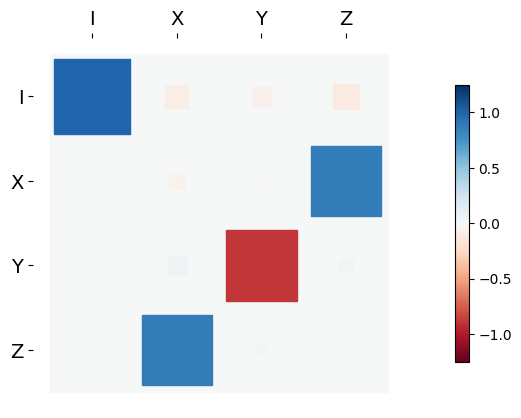

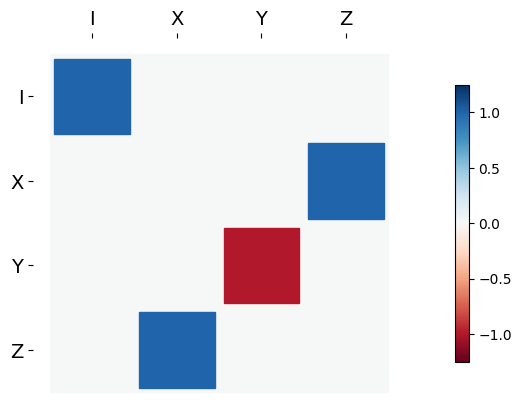

In [20]:
qt.hinton(result.final_states[0])
qt.hinton(result.objectives[0].target)

opt(
    objectives=[Objective(initial, evo, target)],
    pulse_options={
        "x": {
            "guess": [0. for _ in range(len(evo_time))],
            "bounds": [-10, 10],
        },
        "y": {
            "guess": [0. for _ in range(len(evo_time))],
            "bounds": [-10, 10],
        },
    },
    tlist=evo_time,
    kwargs={
        "optimizer": {
            "disp": False,
            "niter": 100,  # = 0: no global search
            "seed": 123,  # deterministic results
            # num of iters without improvement before stopping
            "niter_success": 10,
        },
        "minimizer": {
            "tol": tol,
        },
        "integrator": {
            "progress_bar": False,
            "rtol":rtol, 
            "atol":atol,
        },
    }
)

# Cython

In [ ]:
%load_ext Cython

In [ ]:
%%cython
import numpy as np 

cpdef double sin_cy(double t, double[:] p):
    return p[0] * np.sin(p[1] * t + p[2])

cpdef double grad_sin_cy(double t, double[:] p, int idx):
    if idx==0: return np.sin(p[1] * t + p[2])
    if idx==1: return p[0] * np.cos(p[1] * t + p[2]) * t
    if idx==2: return p[0] * np.cos(p[1] * t + p[2])
    if idx==3: return p[0] * np.cos(p[1] * t + p[2]) * p[1] # w.r.t. time

In [ ]:
evo_cy = [H_d,
          [H_c[0], sin_cy, {"grad": grad_sin_cy}],
          [H_c[1], sin_cy, {"grad": grad_sin_cy}]]

In [ ]:
opt(
    objectives=[Objective(initial, evo_cy, target)],
    pulse_options={
        "sin_x": {
            "guess": [0. for _ in range(3)],
            "bounds": [(-10, 10) for _ in range(3)],
        },
        "sin_y": {
            "guess": [0. for _ in range(3)],
            "bounds": [(-10, 10) for _ in range(3)],
        },
    },
    time_options={
        "evo_time": evo_time,
        "guess": [evo_time[-1]],
        "bounds": [(0, evo_time[-1]*2)],
    },
    optimizer_kwargs = {
        "disp": True,
        "niter": 0,  # = 0: no global search
        "seed": 123,  # deterministic results
        # num of iters without improvement before stopping
        "niter_success": 10,
    },
    minimizer_kwargs = {
        "tol": tol,
    },
    integrator_kwargs = {
        "progress_bar": False,
        "nsteps": 1e8,
        "rtol":rtol, 
        "atol":atol,
    },
)

NameError: name 'evo_time' is not defined

# JAX

In [ ]:
def sin_jax(t, p):
    return p[0] * jnp.sin(p[1] * t + p[2])

def grad_sin_jax(t, p, idx):
    dt, dp = jax.grad(sin_jax, argnums=(0, 1))(t, p)
    return jnp.concatenate((dp, dt), axis=None)[idx]

evo_jax = [H_d,
          [H_c[0], sin_jax, {"grad": grad_sin_jax}],
          [H_c[1], sin_jax, {"grad": grad_sin_jax}]]

In [ ]:
opt(
    objectives=[Objective(initial, evo_jax, target)],
    pulse_options={
        "sin_x": {
            "guess": [0. for _ in range(3)],
            "bounds": [(-10, 10) for _ in range(3)],
        },
        "sin_y": {
            "guess": [0. for _ in range(3)],
            "bounds": [(-10, 10) for _ in range(3)],
        },
    },
    time_options={
        "evo_time": evo_time,
        "guess": [evo_time[-1]],
        "bounds": [(0, evo_time[-1]*2)],
    },
    optimizer_kwargs = {
        "disp": True,
        "niter": 100,  # = 0: no global search
        "seed": 123,  # deterministic results
        # num of iters without improvement before stopping
        "niter_success": 10,
    },
    minimizer_kwargs = {
        "tol": tol,
    },
    integrator_kwargs = {
        "progress_bar": False,
        "method": "diffrax",
        "solver": Dopri5(),
        "stepsize_controller":
            PIDController(
                rtol=rtol,
                atol=atol,
            ),
    },
)

basinhopping step 0: f 0.51127
took $%.2f seconds
basinhopping step 1: f 0.51127 trial_f 0.323203 accepted 0  lowest_f 0.51127
took $%.2f seconds


KeyboardInterrupt: 